# **TASK 1 : DATA LOADING AND PREPROCESSING**




**1.LOAD DATA**

In [ ]:
from sklearn.datasets import load_breast_cancer #the load_breast_cancer() this fn will load a dataset
#sklearn is a library(consist of many modules)
# datasets is a module(a particular .py file consisting of functions and classes) in this library
data = load_breast_cancer()
X = data.data
Y = data.target

**2.INSPECT DATA**

In [ ]:
type(data)
# data is bunch object
# the function returns a bunch object
# so the object is of which class--> Bunch  (sklearn.utils._bunch.Bunch) (_bunch is an internal module inside utils module)

sklearn.utils._bunch.Bunch

In [ ]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [ ]:
data.feature_names[:5]#we will get the first five input features

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness'], dtype='<U23')

In [ ]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [ ]:
data.DESCR

'.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n:Number of Instances: 569\n\n:Number of Attributes: 30 numeric, predictive attributes and the class\n\n:Attribute Information:\n    - radius (mean of distances from center to points on the perimeter)\n    - texture (standard deviation of gray-scale values)\n    - perimeter\n    - area\n    - smoothness (local variation in radius lengths)\n    - compactness (perimeter^2 / area - 1.0)\n    - concavity (severity of concave portions of the contour)\n    - concave points (number of concave portions of the contour)\n    - symmetry\n    - fractal dimension ("coastline approximation" - 1)\n\n    The mean, standard error, and "worst" or largest (mean of the three\n    worst/largest values) of these features were computed for each image,\n    resulting in 30 features.  For instance, field 0 is Mean Radius, field\n    10 is Radius SE, field 

In [ ]:
X.shape

(569, 30)

In [ ]:
Y.shape

(569,)

**3.CREATE HOLD OUT SET (SPLIT THE DATASET)**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)#random_state =42 is random seed but each time you run you get that random value only
Y_train.shape

(398,)

**4.STANDARDISE FEATURES**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#X scaled= X−μ /σ
#some features are in range of 0-100 some in 0-100000 so scale them (eg dist in KNN will become large so we have to scale)


scaler.fit(X_train)# Fit ONLY on the training data to prevent data leakage(dont want to fit the testing data)

#Transform both sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_scaled.shape

(398, 30)

# **TASK 2 : IMPLEMENTATION OF UTILITIES(HELPER FUNCTIONS) BY USING NUMPY**

**1.Activation function**

In [ ]:
#Sigmoid
import numpy as np
def sigmoid(Z): # z is a number equal to w1x1 + w2x2 + b  z is not a numpy array
    """Computes the sigmoid activation: 1 / (1 + e^(-Z))"""
    return 1 / (1 + np.exp(-Z))
#ReLu : rectified linear unit
def relu(Z):
    """Computes the Rectified Linear Unit: max(0, Z)"""
    return np.maximum(0, Z)# if Z>0 then o/p is Z is returned  ifZ<=0 then 0 is returned


 **2.Derivative of Activationfunction**

In [ ]:
#derivative of sigmoid
def sigmoid_derivative(A): # A is also a number
    """Derivative of sigmoid: A * (1 - A), where A = sigmoid(Z)"""
    return A * (1 - A)
#derivative of relu
def relu_derivative(Z):
  """Derivative of relu is 1 if Z > 0, else 0"""
  return np.where(Z > 0, 1, 0)

In [ ]:
np.exp(1)

np.float64(2.718281828459045)

**3.LOSS FUNCTIONS**

In [ ]:
#1.MSE loss function
def compute_mse_loss(Y, Y_hat): # Y and Y_hat are
    """Computes Mean Squared Error Loss (MSE)"""
    m = Y.shape[1]  # assumption : Y will be a 2d array with 1 row and m col where m = no of samples  [[2,3,4,5]]
    loss = np.sum((Y_hat - Y) ** 2) / m #will do operation for each element
    #loss shape is 1,1
    return np.squeeze(loss)   #now converted to scalar
    #np.squeeze will remove all the one dim : eg (1,3)-->(3,)  eg (1,5,1)-->(5,)  eg (1,1)-->scalar : single value

#2.BCE loss function : Binary Cross Entropy
def compute_bce_loss(Y, Y_hat, epsilon=1e-15):
    """Computes Binary Cross-Entropy Loss (BCE)"""
    # Add a small epsilon for numerical stability to avoid log(0)
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon) # operation performed on each ele of 2d array
    m = Y.shape[1] # Number of samples
    # The formula is: -1/m * sum(Y * log(Y_hat) + (1-Y) * log(1-Y_hat))
    loss = -1/m * np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))
    return np.squeeze(loss)


np.clip(minvalue,maxvalue)

arr = np.array([-2, 0, 3, 7, 10])   

clipped_arr = np.clip(arr, 0, 5)

print(clipped_arr)  # Output: [0 0 3 5 5]

 all the values less than min value will become equal to min value and all the values with value greater than max value will become equal to max value

# TASK 3 : IMPLEMENTATION OF ANN CLASSIFIER BY MAKING CLASS


In [ ]:
class MyANNClassifier:
    """ANN Classifier implemented from scratch using only NumPy"""
    #self will be in all member functions as a parameter  : it is instance of object

    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'): #Constructor
        """Initializes the ANN Classifier with given parameters.""" # Store configuration
        self.layer_dims = layer_dims  # layer_dims = [4, 10,8, 1] means input layer has 4 nodes hidden layer1 has 10 nodes and hidden layer 2 has 8 nodes and o/p layer has one node

        self.learning_rate = learning_rate
        self.n_iterations = n_iterations # epoch
        self.loss = loss  #bce as classification
        # Store results
        self.parameters = {} # Dictionary to hold W's and b's
        self.costs = []      # List to store loss at each iteration

    def _initialize_parameters(self):
        """Initializes weights (W) with small random values and biases (b) with zeros."""
        np.random.seed(42) # For reproducibility
        L = len(self.layer_dims) # Number of layers

        for l in range(1, L): # 1 to L-1 ( no work for layer 0 : input layer)
            # Weights Wl: Matrix of shape (current_layer_size, previous_layer_size)
            # Initialized with small random values (0.01 factor) to break symmetry
            self.parameters[f'W{l}'] = np.random.randn(
                self.layer_dims[l], self.layer_dims[l-1]
            ) * 0.01

            # Biases bl: Vector of shape (current_layer_size, 1)
            # Initialized with zeros
            self.parameters[f'b{l}'] = np.zeros((self.layer_dims[l], 1))

    def _forward_propagation(self, X):
        """
        Computes the forward pass to generate predictions (Y_hat).
        Stores linear results (Z) and activations (A) in a cache for backpropagation.
        """
        A_prev = X
        cache = []
        L = len(self.layer_dims) - 1 # Number of layers (W/b pairs)

        # Loop through hidden layers (1 to L-1) - ReLU activation
        for l in range(1, L):
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']

            # Linear step: Z = W @ A_prev + b
            Z = np.dot(W, A_prev) + b

            # Activation step: A = ReLU(Z)
            A = relu(Z)

            cache.append(((A_prev, W, b), Z)) # Store A_prev and Z
            A_prev = A

        # Output Layer (L) - Sigmoid activation
        W = self.parameters[f'W{L}']
        b = self.parameters[f'b{L}']
        Z = np.dot(W, A_prev) + b
        A_L = sigmoid(Z) # Final activation (Y_hat)

        cache.append(((A_prev, W, b), Z)) # Store A_prev and Z for the final layer

        return A_L, cache # Return Y_hat and the cache

    def _backward_propagation(self, Y, Y_hat, cache):
        """
        Computes the backward pass to calculate gradients (dW, db) for all parameters.
        """
        grads = {}
        L = len(self.layer_dims) - 1 # Number of layers
        m = Y.shape[1] # Number of samples

        # --- 1. Initialize Backprop (Derivative of Loss w.r.t Y_hat) ---
        if self.loss == 'bce':
            # Derivative of BCE Loss: -(Y/Y_hat - (1-Y)/(1-Y_hat)) [cite: 96]
            dA_L = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        elif self.loss == 'mse':
            # Derivative of MSE Loss: 2 * (Y_hat - Y)
            dA_L = 2 * (Y_hat - Y)
        else:
            raise ValueError("Invalid loss function specified.")

        # --- 2. Output Layer (L) ---
        ((A_prev, W, b), Z_L) = cache[L-1] # Get final layer components

        # dZ_L = dA_L * g'(Z_L) - derivative of activation (Sigmoid) [cite: 100]
        dZ_L = dA_L * sigmoid_derivative(Y_hat)

        # dW_L = 1/m * dZ_L @ A_prev.T
        grads[f'dW{L}'] = 1/m * np.dot(dZ_L, A_prev.T)

        # db_L = 1/m * sum(dZ_L)
        grads[f'db{L}'] = 1/m * np.sum(dZ_L, axis=1, keepdims=True)

        # dA_prev is needed for the next (L-1) layer
        dA_prev = np.dot(W.T, dZ_L)

        # --- 3. Loop Backwards (Hidden Layers: L-1 down to 1) - ReLU [cite: 102] ---
        for l in reversed(range(L - 1)):
            l_idx = l + 1 # Layer index (1-based)

            # Get components for the current hidden layer (l_idx)
            ((A_prev, W, b), Z_prev) = cache[l_idx-1]
            W_next = self.parameters[f'W{l_idx+1}']

            # dA_l is already computed from the previous step (dA_prev from next layer)

            # dZ_l = dA_l * g'(Z_l) - derivative of activation (ReLU) [cite: 106]
            dZ_l = dA_prev * relu_derivative(Z_prev)

            # dW_l and db_l calculation
            grads[f'dW{l_idx}'] = 1/m * np.dot(dZ_l, A_prev.T)
            grads[f'db{l_idx}'] = 1/m * np.sum(dZ_l, axis=1, keepdims=True)

            # dA_prev for the *next* step in the loop (previous layer) [cite: 105]
            dA_prev = np.dot(W.T, dZ_l)

        return grads # Return all gradients [cite: 108]

    def _update_parameters(self, grads):
        """Updates weights and biases using Gradient Descent."""
        L = len(self.layer_dims) - 1

        for l in range(1, L + 1):
            # Gradient Descent update rule: Parameter = Parameter - learning_rate * Gradient
            self.parameters[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.learning_rate * grads[f'db{l}']

    def fit(self, X, y):
        """Trains the model by running forward/backward propagation for n_iterations."""
        # Reshape data: X should be (n_features, n_samples)
        X_reshaped = X.T
        y_reshaped = y.reshape(1, -1)

        self._initialize_parameters()

        # Training loop
        for i in range(self.n_iterations):
            # 1. Forward Propagation
            Y_hat, cache = self._forward_propagation(X_reshaped)

            # 2. Compute Loss
            if self.loss == 'bce':
                cost = compute_bce_loss(y_reshaped, Y_hat)
            else:
                cost = compute_mse_loss(y_reshaped, Y_hat)

            # 3. Backward Propagation
            grads = self._backward_propagation(y_reshaped, Y_hat, cache)

            # 4. Update Parameters
            self._update_parameters(grads)

            # 5. Store Cost for plotting
            self.costs.append(cost)

            if i % 1000 == 0:
                 print(f"Iteration {i}/{self.n_iterations}, Loss: {cost:.4f}")

    def predict(self, X):
        """Generates binary predictions (0 or 1) for new data."""
        # Reshape X to (n_features, n_samples)
        X_reshaped = X.T

        # Run forward propagation
        Y_hat, _ = self._forward_propagation(X_reshaped)

        # Convert probabilities (Y_hat) to binary predictions (0 or 1) [cite: 131]
        predictions = (Y_hat > 0.5).astype(int)

        # Return flattened 1D array of predictions [cite: 132]
        return predictions.flatten()



# Task 4 and Task 5


--- Task 4: Training and Experimentation ---

--- Model 1: MYANN (BCE, 1 hidden layer) ---
Iteration 0/5000, Loss: 0.6932
Iteration 1000/5000, Loss: 0.6801
Iteration 2000/5000, Loss: 0.6705
Iteration 3000/5000, Loss: 0.6574
Iteration 4000/5000, Loss: 0.6211

Classification Report (Model 1 - BCE):
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        63
           1       0.83      1.00      0.91       108

    accuracy                           0.87       171
   macro avg       0.92      0.83      0.85       171
weighted avg       0.89      0.87      0.86       171


--- Model 2: MYANN (MSE, 1 hidden layer) ---
Iteration 0/5000, Loss: 0.2500
Iteration 1000/5000, Loss: 0.2464
Iteration 2000/5000, Loss: 0.2435
Iteration 3000/5000, Loss: 0.2411
Iteration 4000/5000, Loss: 0.2388

Classification Report (Model 2 - MSE):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1

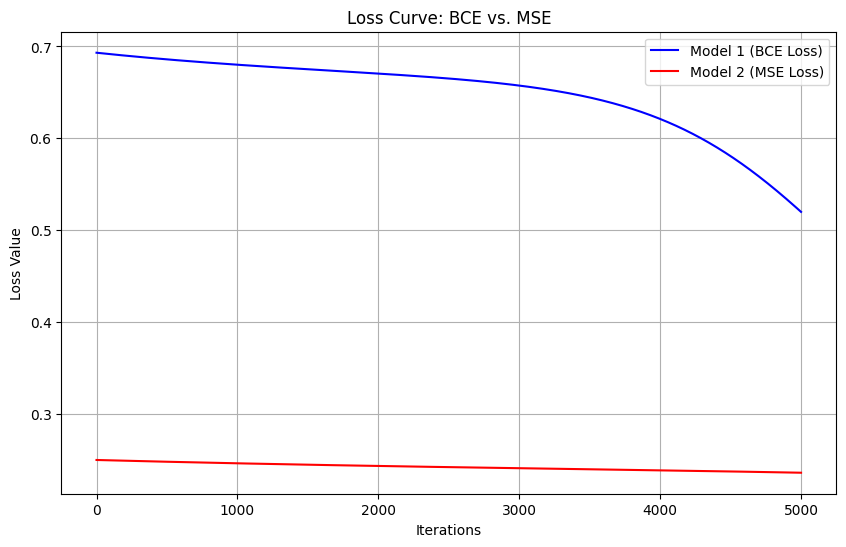

In [ ]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

print("\n--- Task 4: Training and Experimentation ---")

# Define layer dimensions for 1 hidden layer (30 inputs, 10 hidden units, 1 output)
layer_dims_1_hidden = [X_train_scaled.shape[1], 10, 1]
# Define layer dimensions for 2 hidden layers (30 inputs, 10, 5, 1 output)
layer_dims_2_hidden = [X_train_scaled.shape[1], 10, 5, 1]

# --- 1. Model 1 (BCE Loss) ---
print("\n--- Model 1: MYANN (BCE, 1 hidden layer) ---")
model1_bce = MyANNClassifier(
    layer_dims=layer_dims_1_hidden,
    loss='bce',
    learning_rate=0.001,
    n_iterations=5000
)
model1_bce.fit(X_train_scaled, Y_train)
y_pred1 = model1_bce.predict(X_val_scaled)
print("\nClassification Report (Model 1 - BCE):")
print(classification_report(Y_val, y_pred1, zero_division=0))

# --- 2. Model 2 (MSE Loss) ---
print("\n--- Model 2: MYANN (MSE, 1 hidden layer) ---")
model2_mse = MyANNClassifier(
    layer_dims=layer_dims_1_hidden,
    loss='mse',
    learning_rate=0.001,
    n_iterations=5000
)
model2_mse.fit(X_train_scaled, Y_train)
y_pred2 = model2_mse.predict(X_val_scaled)
print("\nClassification Report (Model 2 - MSE):")
print(classification_report(Y_val, y_pred2, zero_division=0))

# --- 3. Model 3 (Deeper Architecture, BCE Loss) ---
print("\n--- Model 3: MYANN (BCE, 2 hidden layers) ---")
model3_deeper = MyANNClassifier(
    layer_dims=layer_dims_2_hidden,
    loss='bce',
    learning_rate=0.001,
    n_iterations=5000
)
model3_deeper.fit(X_train_scaled, Y_train)
y_pred3 = model3_deeper.predict(X_val_scaled)
print("\nClassification Report (Model 3 - BCE Deeper):")
print(classification_report(Y_val, y_pred3, zero_division=0))

# --- Task 5: Comparison with scikit-learn ---
print("\n--- Task 5: scikit-learn MLPClassifier ---")

# Instantiate MLPClassifier (matching parameters as closely as possible)
# (10,) corresponds to one hidden layer with 10 units
mlp_sk = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam', # adam is an advanced optimizer, often better than simple GD
    max_iter=5000, # Use a high number to match our custom model's iterations
    learning_rate_init=0.001,
    random_state=42
)
mlp_sk.fit(X_train_scaled, Y_train)
y_pred_sk = mlp_sk.predict(X_val_scaled)

print("\nClassification Report (MLPClassifier - scikit-learn):")
print(classification_report(Y_val, y_pred_sk, zero_division=0))

# --- Loss Curve Plot (Required for Report) ---
plt.figure(figsize=(10, 6))
plt.plot(model1_bce.costs, label='Model 1 (BCE Loss)', color='blue')
plt.plot(model2_mse.costs, label='Model 2 (MSE Loss)', color='red')
plt.title('Loss Curve: BCE vs. MSE')
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()